In [1]:
import tensorflow as tf
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.decomposition import PCA
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Comments for documentation:
# - `import tensorflow as tf`: Import TensorFlow for building and training machine learning models.
# - `import os`: Import os module to interact with the operating system, e.g., reading file paths.
# - `import pandas as pd`: Import pandas for data manipulation and analysis.
# - `import numpy as np`: Import NumPy for numerical operations on arrays and matrices.
# - `import matplotlib as plt`: Import matplotlib for creating static, interactive, and animated visualizations in Python.
# - `from sklearn.metrics import mean_squared_error as mse`: Import mean_squared_error from sklearn for calculating the MSE metric for model evaluation.
# - `from sklearn.preprocessing import MinMaxScaler`: Import MinMaxScaler from sklearn for feature scaling by normalizing or standardizing features.
# - `import warnings`: Import warnings module to suppress warnings.
# - `import matplotlib.pyplot as plt`: Import pyplot from matplotlib for plotting graphs.
# - `warnings.filterwarnings('ignore')`: Set up warnings to ignore them to avoid clutter in the output.
# - `%matplotlib inline`: Enable inline plotting for Jupyter notebooks, making plots appear in the notebook itself.


In [32]:
df = pd.read_csv('Timeseries_14_P.csv', skiprows=10)
season = {'Winter':1,'Spring':2,'Summer':3,'Autumn':4}
df = df[:157776:]
df.index = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')
df.tail()

time    P  Gb(i)  Gd(i)  Gr(i)  H_sun    T2m  \
time                                                                         
2022-12-31 19:07:00  20221231:1907  0.0    0.0    0.0    0.0    0.0  17.97   
2022-12-31 20:07:00  20221231:2007  0.0    0.0    0.0    0.0    0.0  16.78   
2022-12-31 21:07:00  20221231:2107  0.0    0.0    0.0    0.0    0.0  16.28   
2022-12-31 22:07:00  20221231:2207  0.0    0.0    0.0    0.0    0.0  15.60   
2022-12-31 23:07:00  20221231:2307  0.0    0.0    0.0    0.0    0.0  15.21   

                     WS10m  Int  
time                             
2022-12-31 19:07:00   1.93  0.0  
2022-12-31 20:07:00   2.00  0.0  
2022-12-31 21:07:00   2.07  0.0  
2022-12-31 22:07:00   2.07  0.0  
2022-12-31 23:07:00   1.86  0.0

In [33]:
df['Gb(i)'] = pd.to_numeric(df['Gb(i)'], errors='coerce')
df['P'] = pd.to_numeric(df['P'], errors='coerce')

day  = 60 * 60 * 24
year =  365.2425 * day
month = 30 * day

df["Seconds"] = df.index.map(pd.Timestamp.timestamp)
df ["day sin"] = np.sin(df['Seconds'] * ( 2 * np.pi /day))
df ["day cos"] = np.cos(df['Seconds'] * ( 2 * np.pi /day))
# df ["year sin"] = np.sin(df['Seconds'] * ( 2 * np.pi /year))
# df ["year cos"] = np.cos(df['Seconds'] * ( 2 * np.pi /year))

# 1971
df = df.drop(["Seconds"], axis = 1)

# Check for any NaN values after conversion
# print("NaN values in G(i):", df['G(i)'].isna().sum())
df= df[df['Gb(i)'] > 10]

def get_season(month):
    if month in [12, 1, 2]:
        return season['Winter']
    elif month in [3, 4, 5]:
        return season['Spring']
    elif month in [6, 7, 8]:
        return season['Summer']
    elif month in [9, 10, 11]:
        return season['Autumn']

# Apply the function to create the season column
df['Season'] = df.index.month.map(get_season)

# Load data into DataFrame
data = df.copy()
data.drop(['Int'], axis = 1,inplace=True)

# Ensure 'time' column is of string type
data['time'] = data['time'].astype(str)

# Validate 'time' column format and filter rows with valid datetime-like strings
valid_time_format = r'^\d{8}:\d{4}$'
data = data[data['time'].str.match(valid_time_format, na=False)]

# Convert 'time' column to datetime
data['time'] = pd.to_datetime(data['time'], format='%Y%m%d:%H%M')

# Set 'time' as the index
data.set_index('time', inplace=True)

# Convert all columns to numeric, coercing errors to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Handle missing values by filling with the mean of each column
data.fillna(data.mean(), inplace=True)

# print(data.describe())

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# Fit and transform the data
scaled_data = scaler.fit_transform(data)

# Create a new DataFrame with scaled data, preserving column names and index
scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Display the first few rows and basic statistics to confirm
# print(scaled_df.head())


print(scaled_df.head(15))
data=scaled_df


                            P     Gb(i)     Gd(i)     Gr(i)     H_sun  \
time                                                                    
2005-01-01 05:07:00  0.257588  0.203621  0.125441  0.143048  0.159010   
2005-01-01 06:07:00  0.552400  0.476019  0.203267  0.363636  0.303618   
2005-01-01 07:07:00  0.741795  0.673444  0.263173  0.550802  0.432635   
2005-01-01 08:07:00  0.858976  0.804593  0.309975  0.689840  0.533801   
2005-01-01 09:07:00  0.906380  0.866984  0.338699  0.770053  0.587955   
2005-01-01 10:07:00  0.888409  0.849780  0.356738  0.779412  0.578553   
2005-01-01 11:07:00  0.814368  0.759558  0.360366  0.720588  0.508926   
2005-01-01 12:07:00  0.685003  0.610357  0.337252  0.598930  0.398119   
2005-01-01 13:07:00  0.499033  0.419178  0.288784  0.426471  0.263866   
2005-01-01 14:07:00  0.230788  0.154035  0.247215  0.201872  0.116163   
2005-01-02 05:07:00  0.268630  0.213015  0.124410  0.147059  0.158296   
2005-01-02 06:07:00  0.550455  0.470046  0.217460  

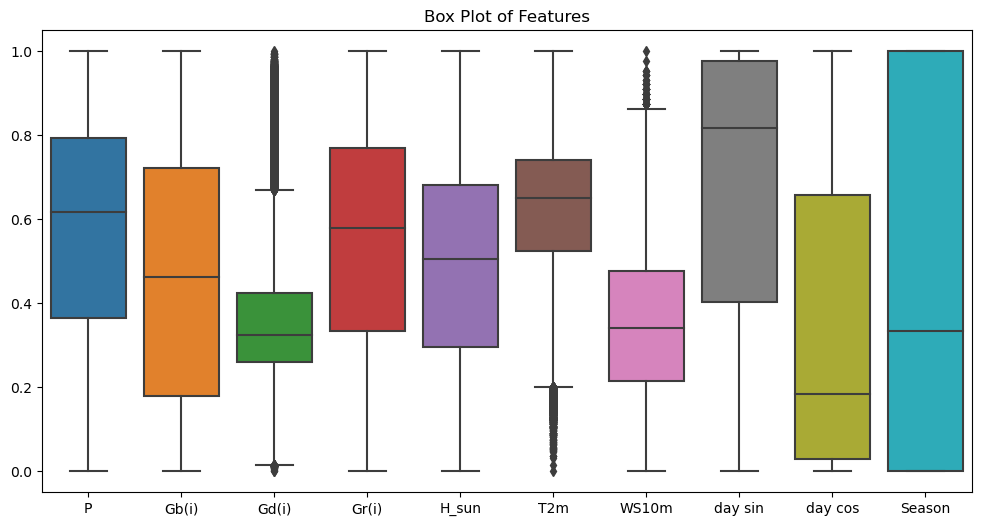

In [34]:
# Box Plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=data)
plt.title('Box Plot of Features')
plt.show()

                            P     Gb(i)     Gd(i)     Gr(i)     H_sun  \
time                                                                    
2005-01-01 05:07:00  0.257588  0.203621  0.125441  0.143048  0.159010   
2005-01-01 06:07:00  0.552400  0.476019  0.203267  0.363636  0.303618   
2005-01-01 07:07:00  0.741795  0.673444  0.263173  0.550802  0.432635   
2005-01-01 08:07:00  0.858976  0.804593  0.309975  0.689840  0.533801   
2005-01-01 09:07:00  0.906380  0.866984  0.338699  0.770053  0.587955   
2005-01-01 10:07:00  0.888409  0.849780  0.356738  0.779412  0.578553   
2005-01-01 11:07:00  0.814368  0.759558  0.360366  0.720588  0.508926   
2005-01-01 12:07:00  0.685003  0.610357  0.337252  0.598930  0.398119   
2005-01-01 13:07:00  0.499033  0.419178  0.288784  0.426471  0.263866   
2005-01-01 14:07:00  0.230788  0.154035  0.247215  0.201872  0.116163   

                          T2m     WS10m   day sin       day cos  Season  
time                                             

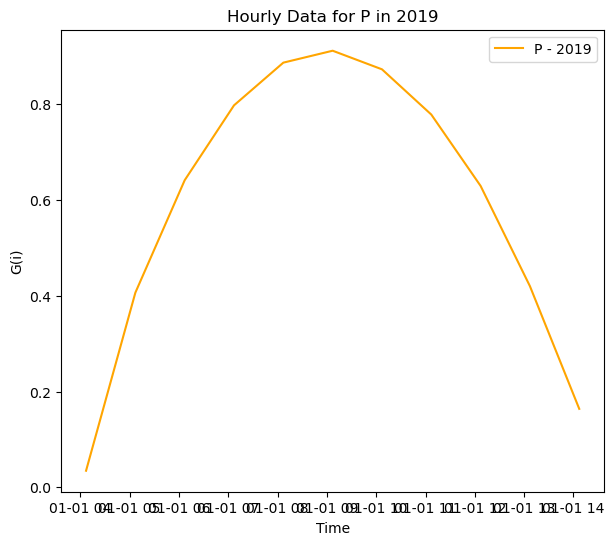

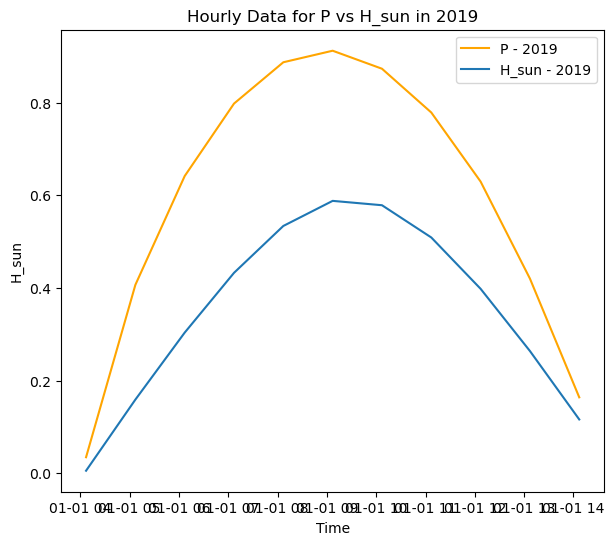

In [35]:
# TODO Merhawi
# this for hourly basis
# Now resample to hourly intervals
data_hourly = data.copy()

# Verify index is DatetimeIndex
print(data_hourly.head(10))

# Continue with plotting code as before
# Get unique years in the dataset
#years = data_hourly.index.year.unique()



data_2019 = data_hourly[(data_hourly.index.year == 2019) & (data_hourly.index.month == 1) &
                        (data_hourly.index.day == 1)]
print(data_2019)

# this is plot for G (i) vesrus wiht h_sun
plt.figure(figsize=(7,6))
plt.plot(data_2019.index, data_2019['P'], color='orange', label='P - 2019')
plt.title('Hourly Data for P in 2019')
plt.xlabel('Time')
plt.ylabel('G(i)')
plt.legend()
plt.show()
    

plt.figure(figsize=(7, 6))
plt.plot(data_2019.index, data_2019['P'], color='orange', label='P - 2019')
plt.plot(data_2019.index, data_2019['H_sun'], label='H_sun - 2019')
plt.title('Hourly Data for P vs H_sun in 2019')
plt.xlabel('Time')
plt.ylabel('H_sun')
plt.legend()
plt.show()

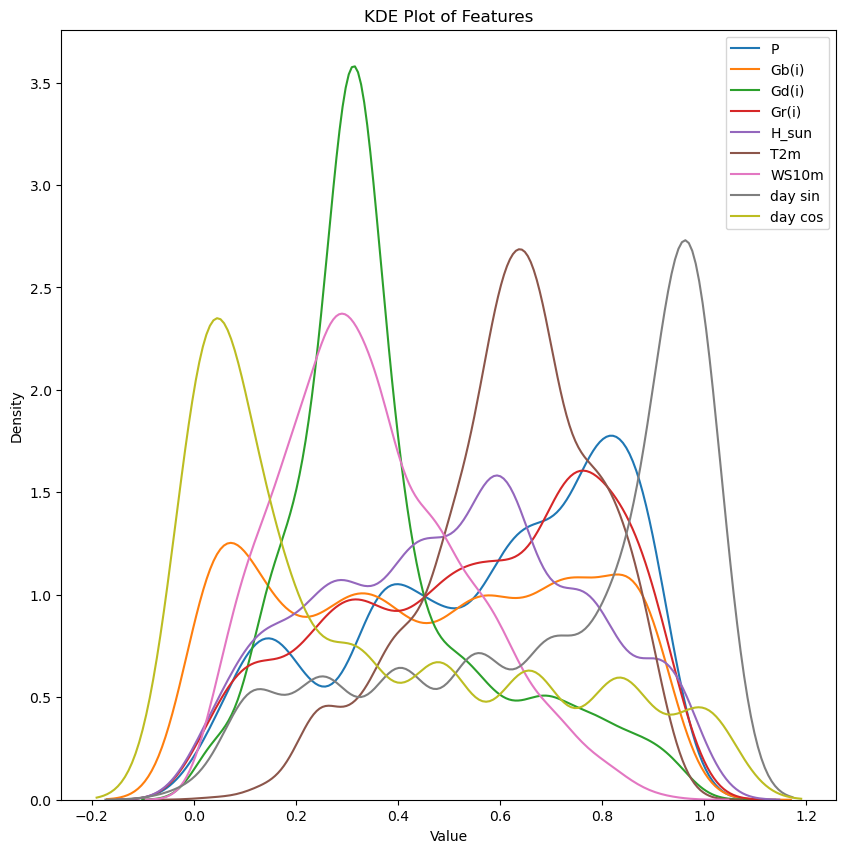

In [36]:
data.drop(['Season'], axis=1, inplace=True)
data_2019 = data[(data.index.year == 2019)]
# Additional KDE Plot for each feature to observe distribution
plt.figure(figsize=(10, 10))
for column in data_2019.columns:
    sns.kdeplot(data_2019[column] , label=column)
plt.title('KDE Plot of Features')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


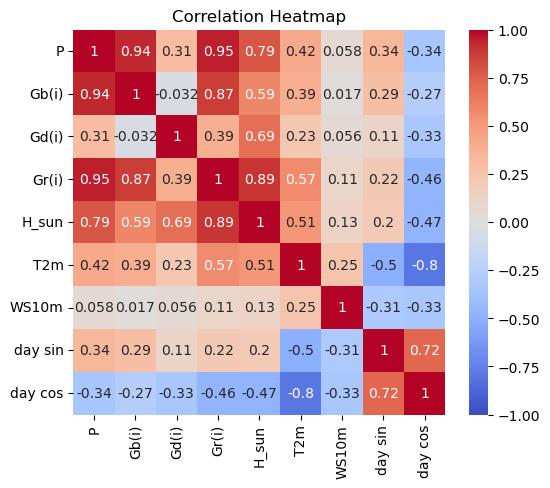

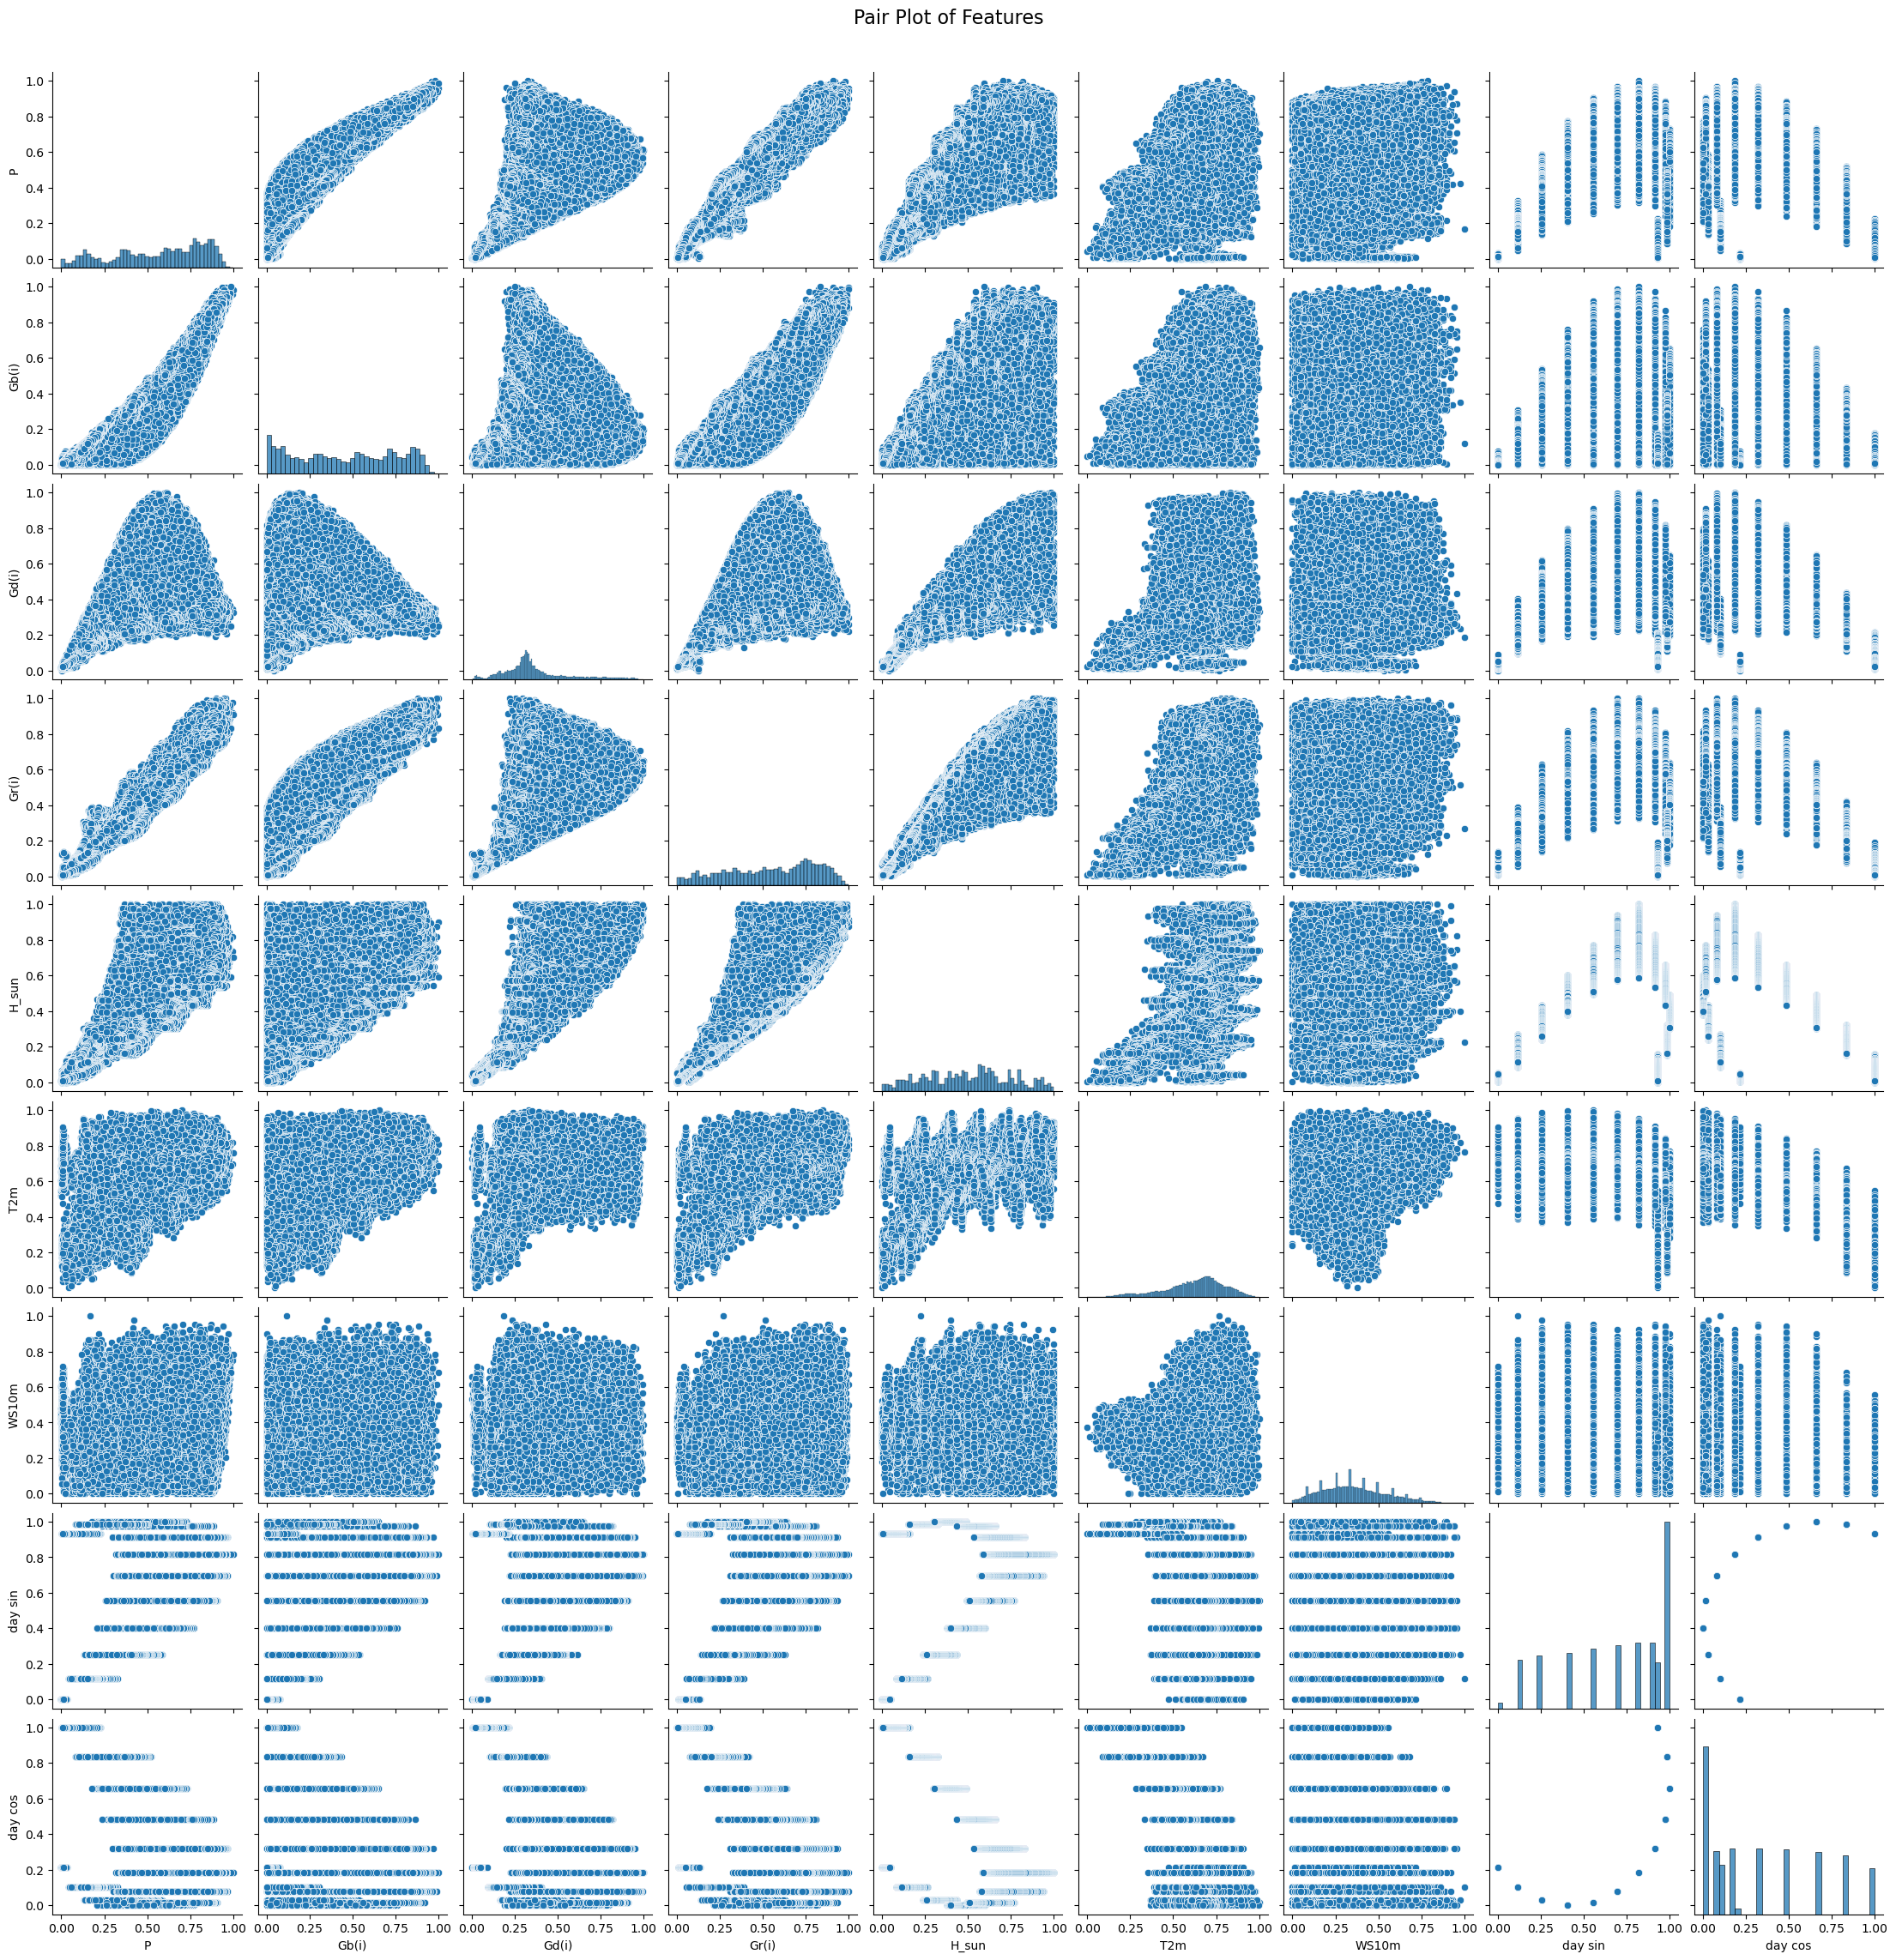

In [37]:
 ## Correlation Analysis
# Correlation Heatmap
plt.figure(figsize=(6, 5))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Pair Plot for Visualizing Relationships Between Features
sns.pairplot(data, palette='bright')
plt.suptitle('Pair Plot of Features', y=1.02, fontsize=16)
plt.show()


In [38]:
df.drop(['Gb(i)', 'Gr(i)'], axis = 1,inplace=True)

In [39]:
df.drop(['Int', 'time'], axis = 1,inplace=True)
df_multi = df.iloc[:,:]  # Select columns from index 1 to 4 (inclusive), typically removing the time column assuming it's at index 0.

df.tail(30)  # Display the last 30 rows of the DataFrame to check the end of the dataset.

print(df_multi.head(10))  # Print the first 10 rows of the subset DataFrame to verify the correct columns and data.

print(df_multi.dtypes)  # Print the data types of the columns in the subset DataFrame to ensure they are appropriate for further analysis.


                          P   Gd(i)  H_sun    T2m  WS10m   day sin   day cos  \
time                                                                           
2005-01-01 05:07:00  226.87   68.47  15.66  12.14   2.34  0.973379  0.229200   
2005-01-01 06:07:00  479.99  107.73  27.81  17.47   2.41  0.999534 -0.030539   
2005-01-01 07:07:00  642.60  137.95  38.65  21.50   2.83  0.957571 -0.288196   
2005-01-01 08:07:00  743.21  161.56  47.15  24.20   3.17  0.850352 -0.526214   
2005-01-01 09:07:00  783.91  176.05  51.70  26.10   2.97  0.685183 -0.728371   
2005-01-01 10:07:00  768.48  185.15  50.91  27.38   2.55  0.473320 -0.880891   
2005-01-01 11:07:00  704.91  186.98  45.06  28.09   2.21  0.229200 -0.973379   
2005-01-01 12:07:00  593.84  175.32  35.75  28.32   2.00 -0.030539 -0.999534   
2005-01-01 13:07:00  434.17  150.87  24.47  28.01   1.86 -0.288196 -0.957571   
2005-01-01 14:07:00  203.86  129.90  12.06  27.02   1.86 -0.526214 -0.850352   

                     Season  
time     

In [40]:
# ToDo Merhawi Check the result by using MinMaxScaler() 
# Initialize MinMaxScaler
scaler = StandardScaler() 

# Fit and transform the data
scaled_data = scaler.fit_transform(df_multi)

# Create a new DataFrame with scaled data, preserving column names and index
scaled_df = pd.DataFrame(scaled_data, columns=df_multi.columns, index=df_multi.index)

# Display the first few rows and basic statistics to confirm
print(scaled_df.head())

                            P     Gd(i)     H_sun       T2m     WS10m  \
time                                                                    
2005-01-01 05:07:00 -1.171045 -1.271716 -1.351160 -2.423919  0.164565   
2005-01-01 06:07:00 -0.048752 -0.864098 -0.777408 -1.357754  0.228618   
2005-01-01 07:07:00  0.672235 -0.550338 -0.265517 -0.551629  0.612936   
2005-01-01 08:07:00  1.118323 -0.305206  0.135874 -0.011546  0.924050   
2005-01-01 09:07:00  1.298781 -0.154763  0.350736  0.368513  0.741042   

                      day sin   day cos    Season  
time                                               
2005-01-01 05:07:00  0.932523  1.550648 -1.259713  
2005-01-01 06:07:00  0.983203  1.007636 -1.259713  
2005-01-01 07:07:00  0.901892  0.468975 -1.259713  
2005-01-01 08:07:00  0.694131 -0.028626 -1.259713  
2005-01-01 09:07:00  0.374080 -0.451257 -1.259713  


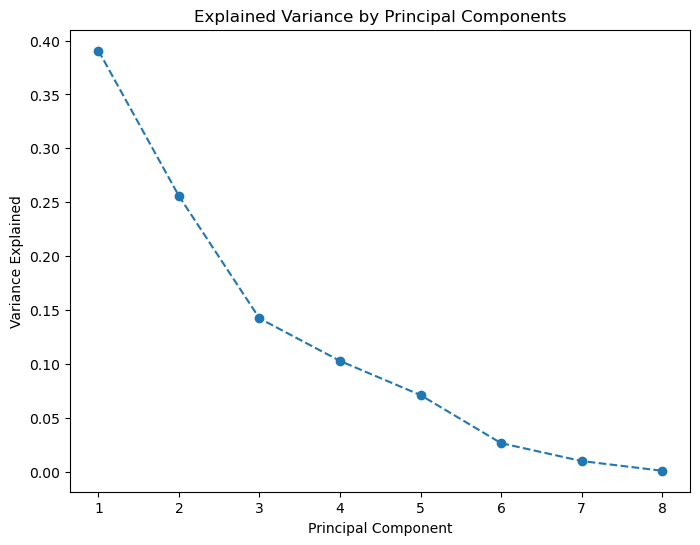

Explained variance by each principal component:
Principal Component 1: 0.39
Principal Component 2: 0.26
Principal Component 3: 0.14
Principal Component 4: 0.10
Principal Component 5: 0.07
Principal Component 6: 0.03
Principal Component 7: 0.01
Principal Component 8: 0.00
Principal Components:
          P     Gd(i)     H_sun       T2m     WS10m   day sin   day cos  \
0 -0.367316 -0.331317 -0.462977 -0.473338 -0.205762  0.187752  0.488930   
1 -0.368662 -0.317309 -0.367551  0.210742  0.265624 -0.620942 -0.292675   
2 -0.375183  0.364274 -0.034181 -0.111588 -0.049843 -0.230957 -0.080568   
3 -0.024311  0.096770  0.041193 -0.252246  0.931493  0.160868  0.173455   
4 -0.410089  0.702823  0.028263 -0.155821 -0.099973 -0.047792  0.001924   
5  0.371592 -0.015712 -0.039286 -0.768698 -0.066771 -0.252540 -0.445639   
6 -0.416587 -0.373126  0.794220 -0.199947 -0.043513 -0.108251  0.014202   
7 -0.328657 -0.118553 -0.120691  0.017417  0.024409  0.649755 -0.663258   

     Season  
0 -0.016446  
1 

In [41]:
pca = PCA(n_components=None)  # Setting n_components=None keeps all components
pca.fit(scaled_df)

# Step 3: Transform the data
data_pca = pca.transform(scaled_df)

# Step 4: Explained variance plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')
plt.show()

# Print the explained variance of each component
print("Explained variance by each principal component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"Principal Component {i + 1}: {var:.2f}")

# Step 5: Optionally, you can create a DataFrame of the PCA components
# This shows how much each original feature contributes to each principal component
pca_df = pd.DataFrame(pca.components_, columns=df_multi.columns)
print("Principal Components:")
print(pca_df)

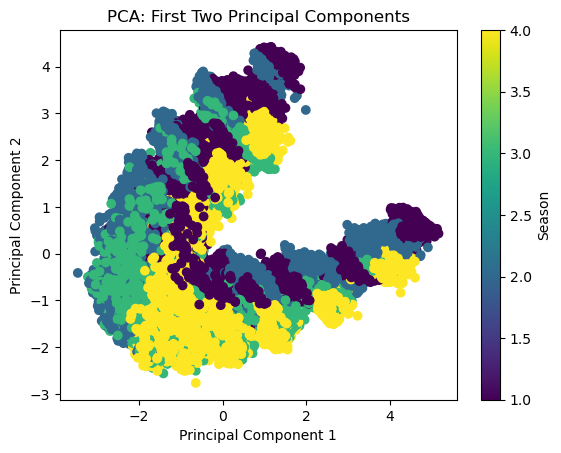

In [42]:
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=df_multi['Season'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Season')
plt.title('PCA: First Two Principal Components')
plt.show()

In [43]:
def df_to_X_y(df_as_np, window_size=5):
#   df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size,:]]
    X.append(row)
    label = df_as_np[i+window_size,0]
    y.append(label)
  return np.array(X), np.array(y)

In [44]:
WINDOW_SIZE = 5 
df_scaled = scaled_df.to_numpy()
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)
print(X1[0])
print("#############################")
print(y1[0])
X1.shape, y1.shape

[[-1.17104471 -1.27171635 -1.35116015 -2.42391852  0.16456456  0.9325229
   1.5506478  -1.25971323]
 [-0.04875152 -0.864098   -0.77740775 -1.35775388  0.22861759  0.9832026
   1.00763595 -1.25971323]
 [ 0.67223495 -0.55033778 -0.26551672 -0.55162939  0.61293577  0.90189166
   0.46897497 -1.25971323]
 [ 1.11832344 -0.30520611  0.13587385 -0.01154598  0.9240505   0.69413127
  -0.02862629 -1.25971323]
 [ 1.29878066 -0.15476317  0.35073587  0.36851271  0.74104184  0.37407997
  -0.45125713 -1.25971323]]
#############################
1.230366533268442


((62983, 5, 8), (62983,))

In [20]:
df_winter = scaler.transform(df_multi[df_multi['Season'] == 1])
df_spring = scaler.transform(df_multi[df_multi['Season'] == 2])
df_summer = scaler.transform(df_multi[df_multi['Season'] == 3])
df_fall = scaler.transform(df_multi[df_multi['Season'] == 4])
df_winter

array([[-1.16914488, -1.27294042, -1.35141928, ...,  0.93177163,
         1.54912882, -1.25948647],
       [-0.04625158, -0.86562066, -0.77762614, ...,  0.98246764,
         1.00628719, -1.25948647],
       [ 0.67512041, -0.55209027, -0.26569875, ...,  0.90113053,
         0.46779507, -1.25948647],
       ...,
       [ 0.16327058, -0.19010895, -0.41020962, ..., -1.0141632 ,
        -1.0188652 , -1.25948647],
       [-0.60894037, -0.62388479, -0.9433886 , ..., -1.51359175,
        -0.93116619, -1.25948647],
       [-1.57000075, -1.19232721, -1.52898819, ..., -1.9749511 ,
        -0.70708343, -1.25948647]])

In [46]:
df.shape

(62988, 8)

In [21]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)
X_winter, y_winter = df_to_X_y(df_winter, WINDOW_SIZE)
X_spring, y_spring = df_to_X_y(df_spring, WINDOW_SIZE)
X_summer, y_summer = df_to_X_y(df_summer, WINDOW_SIZE)
X_fall, y_fall = df_to_X_y(df_fall, WINDOW_SIZE)
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)

In [47]:
X_train1, y_train1 = X1[:42832], y1[:42832] 
X_val1, y_val1 = X1[42833:53540], y1[42833:53540]
X_test1, y_test1 = X1[53541:], y1[53541:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((42832, 5, 8), (42832,), (10707, 5, 8), (10707,), (9442, 5, 8), (9442,))

In [48]:
# Define custom metrics
def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mba(y_true, y_pred):
    return K.mean(K.abs(K.mean(y_pred - y_true)))

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))  # Root Mean Squared Error

# SIMPLE LSTM

In [49]:

# ---------------------------------------------
# Model Definition
# ---------------------------------------------

# Replace 'seq_length' and 'num_features' with actual values
seq_length = 5       # For example, using past 24 hours
num_features = 8      # Number of features in your dataset

def build_optimized_model_LSTM():
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(units=128, return_sequences=True, input_shape=(seq_length, num_features)))
    model.add(Dropout(rate=0.1))
    
    # Second LSTM layer
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(rate=0.1))
    
    # Third LSTM layer
    model.add(LSTM(units=32))
    model.add(Dropout(rate=0.1))
    
    # Fully connected layer
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(rate=0.1))
    
    # Output layer
    model.add(Dense(1))  # Output layer for regression
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss=Huber(delta=1.0),
        metrics=['mae']
    )
    
    return model

# Instantiate the model
model_simple_lstm = build_optimized_model_LSTM()

# ---------------------------------------------
# Callbacks
# ---------------------------------------------

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode='min'
)

model_checkpoint = ModelCheckpoint(
    'model_optimized_best_1.keras',
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1
)


history_LSTM = model_simple_lstm.fit(
    X_train1, y_train1,
    epochs=50,
    batch_size=64,  # Adjust based on your system's memory capacity
    validation_data=(X_val1, y_val1),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    verbose=1,
    shuffle=False
)


Epoch 1/50
666/670 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1975 - mae: 0.4927
Epoch 1: val_loss improved from inf to 0.10627, saving model to model_optimized_best_1.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1971 - mae: 0.4920 - val_loss: 0.1063 - val_mae: 0.3600 - learning_rate: 5.0000e-04
Epoch 2/50
667/670 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0880 - mae: 0.3138
Epoch 2: val_loss improved from 0.10627 to 0.07608, saving model to model_optimized_best_1.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0880 - mae: 0.3137 - val_loss: 0.0761 - val_mae: 0.2786 - learning_rate: 5.0000e-04
Epoch 3/50
668/670 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0680 - mae: 0.2624
Epoch 3: val_loss improved from 0.07608 to 0.06598, saving model to model_optimized_best_1.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0680 - mae: 0.2624 - val_loss: 0.0660 - val_mae: 0.2394 - learning_rate: 5.0000e-04
Epoch 4/50
669/670 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.061

670/670 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0522 - mae: 0.2143
Epoch 23: val_loss did not improve from 0.05256
670/670 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0522 - mae: 0.2143 - val_loss: 0.0537 - val_mae: 0.2032 - learning_rate: 5.0000e-04
Epoch 24/50
663/670 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0521 - mae: 0.2138
Epoch 24: val_loss improved from 0.05256 to 0.05216, saving model to model_optimized_best_1.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0521 - mae: 0.2138 - val_loss: 0.0522 - val_mae: 0.1929 - learning_rate: 5.0000e-04
Epoch 25/50
664/670 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0517 - mae: 0.2127
Epoch 25: val_loss did not improve from 0.05216
670/670 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0517 - mae: 0.2127 - val_loss: 0.0524 - val_mae: 0.1917 - learning_rate: 5.0000e-04
Epoch 26/50
670/670 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0517 - mae: 0.2118
Epoch 26: val_loss improved from 0.05216 to 0.05196, saving model to model_optimized_

Epoch 46/50
667/670 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0477 - mae: 0.2015
Epoch 46: val_loss did not improve from 0.04929
670/670 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0477 - mae: 0.2015 - val_loss: 0.0493 - val_mae: 0.1830 - learning_rate: 5.0000e-05
Epoch 47/50
670/670 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0477 - mae: 0.2019
Epoch 47: val_loss did not improve from 0.04929
670/670 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0477 - mae: 0.2019 - val_loss: 0.0493 - val_mae: 0.1828 - learning_rate: 5.0000e-05
Epoch 48/50
661/670 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0479 - mae: 0.2021
Epoch 48: val_loss did not improve from 0.04929

Epoch 48: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.
670/670 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0479 - mae: 0.2020 - val_loss: 0.0493 - val_mae: 0.1823 - learning_rate: 5.0000e-05
Epoch 49/50
666/670 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0478 - mae: 0.2030
Epoch 49: val_loss improved from 0.04929 to 0

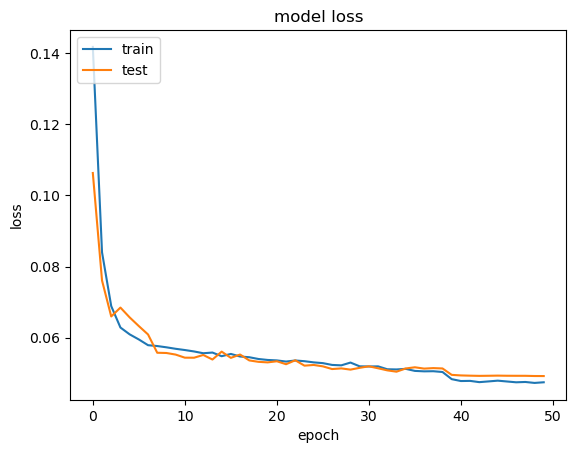

In [50]:
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


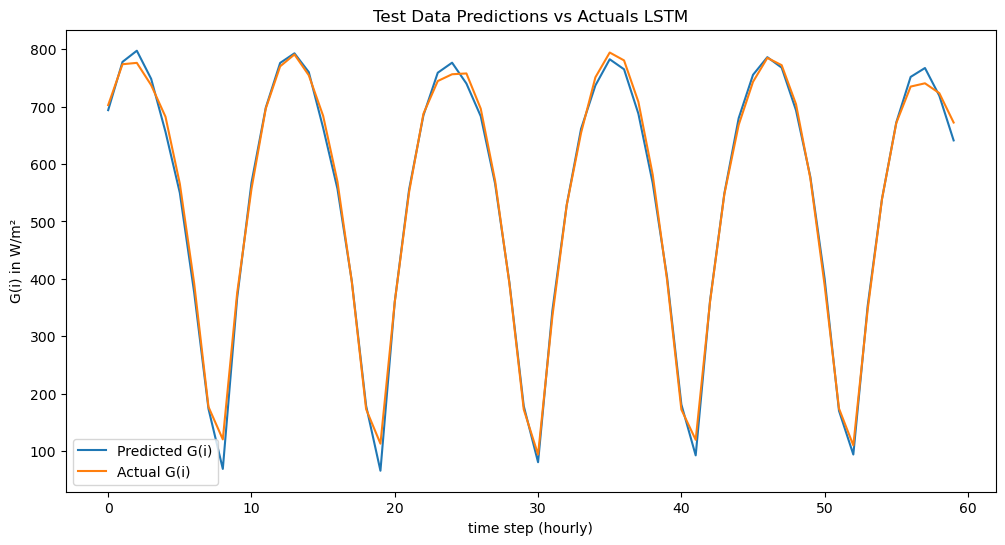

In [53]:
 # Access the mean and standard deviation for the first feature
data_mean = scaler.mean_[0]
data_std = scaler.scale_[0]

# Predict on the test set and flatten the output
Test_prediction = model_simple_lstm.predict(X_test1).flatten()

# Manually inverse transform the predictions and actuals
Test_Predictions_transformed = Test_prediction * data_std + data_mean
y_test1_transformed = y_test1 * data_std + data_mean

# Prepare the DataFrame with actual and predicted values
test_results = pd.DataFrame({
    'Test Predictions': Test_Predictions_transformed,
    'Actuals': y_test1_transformed
})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(test_results['Test Predictions'][0:60], label="Predicted G(i)")
plt.plot(test_results['Actuals'][0:60], label="Actual G(i)")
plt.ylabel('G(i) in W/m²')
plt.xlabel("time step (hourly)")
plt.title('Test Data Predictions vs Actuals LSTM')
plt.legend()
plt.show()



In [54]:
# Define metrics using NumPy
def mae_np(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mba_np(y_true, y_pred):
    return np.abs(np.mean(y_pred - y_true))

def rmse_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

# Actual and predicted values

Train_prediction_ERR = model_simple_lstm.predict(X_test1).flatten()

# Manually inverse transform the predictions and actuals
# Prepare the DataFrame with actual and predicted values
train_results = pd.DataFrame({
    'Test Predictions': Train_prediction_ERR,
    'Actuals': y_test1
})
y_true = train_results['Test Predictions'][0:60].values
y_pred = train_results['Actuals'][0:60]

# Calculate metrics
mae_value = mae_np(y_true, y_pred)
mba_value = mba_np(y_true, y_pred)
rmse_value = rmse_np(y_true, y_pred)

print("MAE:", mae_value)
print("MBA:", mba_value)
print("RMSE:", rmse_value)

def mae_np(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mba_np(y_true, y_pred):
    return np.mean(y_pred - y_true)

def rmse_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 0.05000149600846953
MBA: 0.014443792951317263
RMSE: 0.0677698070649223


# COMPLEX LSTM

In [57]:
# Define model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=32), 
                   return_sequences=True, input_shape=(5, 8)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    # Second LSTM layer
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=32), 
                   return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    # Third LSTM layer (using Bidirectional)
    model.add(Bidirectional(LSTM(units=hp.Int('units_3', min_value=32, max_value=128, step=32), 
                                 return_sequences=False)))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    # Fully connected layer
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))  # Adjust output layer based on your task (e.g., regression or classification)

    # Compile the model with custom metrics
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss=MeanSquaredError(),
        metrics=[mae, mba, rmse]
    )

    return model

# Set up Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='kt_dir',
    project_name='lstm_tuning'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1, mode='min')
cp1 = ModelCheckpoint('model_P/model_lstm_complex_best.keras', save_best_only=True)

# Perform the hyperparameter search
tuner.search(
    X_train1, y_train1,
    epochs=50,
    validation_data=(X_val1, y_val1),
    callbacks=[early_stopping, cp1]
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# You can print the best hyperparameters as well
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hyperparameters.values)

# Fit the best model on the full dataset
history_lstm = best_model.fit(
    X_train1, y_train1,
    validation_data=(X_val1, y_val1),
    epochs=50,
    callbacks=[early_stopping, cp1]
)


Trial 30 Complete [00h 01m 37s]
val_loss: 0.1078668013215065

Best val_loss So Far: 0.10694944113492966
Total elapsed time: 00h 19m 54s
Best hyperparameters: {'units_1': 128, 'dropout_1': 0.30000000000000004, 'units_2': 96, 'dropout_2': 0.2, 'units_3': 128, 'dropout_3': 0.30000000000000004, 'dense_units': 64, 'dropout_4': 0.4, 'learning_rate': 0.0015226984419050577, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0015'}
Epoch 1/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.1230 - mae: 1.0852 - mba: 0.0553 - rmse: 1.3523 - val_loss: 0.1098 - val_mae: 1.0889 - val_mba: 0.0589 - val_rmse: 1.3614
Epoch 2/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.1245 - mae: 1.0860 - mba: 0.0564 - rmse: 1.3542 - val_loss: 0.1091 - val_mae: 1.0604 - val_mba: 0.0533 - val_rmse: 1.3302
Epoch 3/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.1246 - mae: 1.0822 - mba: 0.0543 - rmse: 1.3489 - val_loss: 0.1099 - val_mae: 1

In [58]:
test_loss, test_mae, test_mba, test_rmse = best_model.evaluate(X_test1, y_test1)
print(f'Test MAE: {test_mae}, Test MBA: {test_mba}, Test RMAE: {test_rmse}%')

296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1017 - mae: 1.0324 - mba: 0.0470 - rmse: 1.2878
Test MAE: 1.0453993082046509, Test MBA: 0.0525735467672348, Test RMAE: 1.3049545288085938%


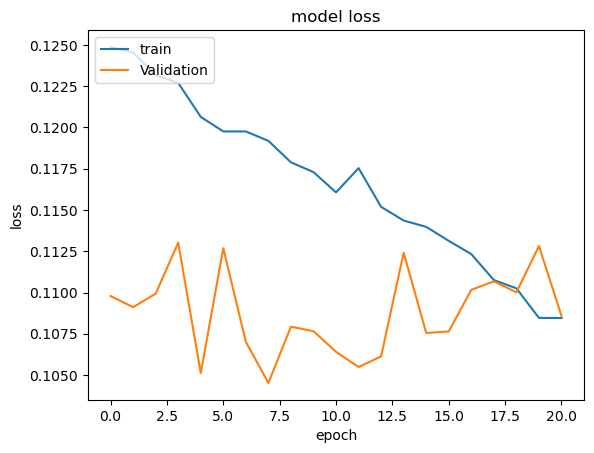

In [59]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0357 - mae: 1.1489 - mba: 0.0332 - rmse: 1.4506
Test MAE: winter, Test MBA: 0.03726893663406372, Test RMAE: 1.4589848518371582%
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1567 - mae: 0.8795 - mba: 0.0615 - rmse: 1.0856
Test MAE: summer, Test MBA: 0.0693788155913353, Test RMAE: 1.0835514068603516%
549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0673 - mae: 1.0831 - mba: 0.0393 - rmse: 1.3551
Test MAE: spring, Test MBA: 0.03904826194047928, Test RMAE: 1.3432315587997437%
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0891 - mae: 1.1057 - mba: 0.0411 - rmse: 1.3784
Test MAE: fall, Test MBA: 0.044747211039066315, Test RMAE: 1.3725497722625732%


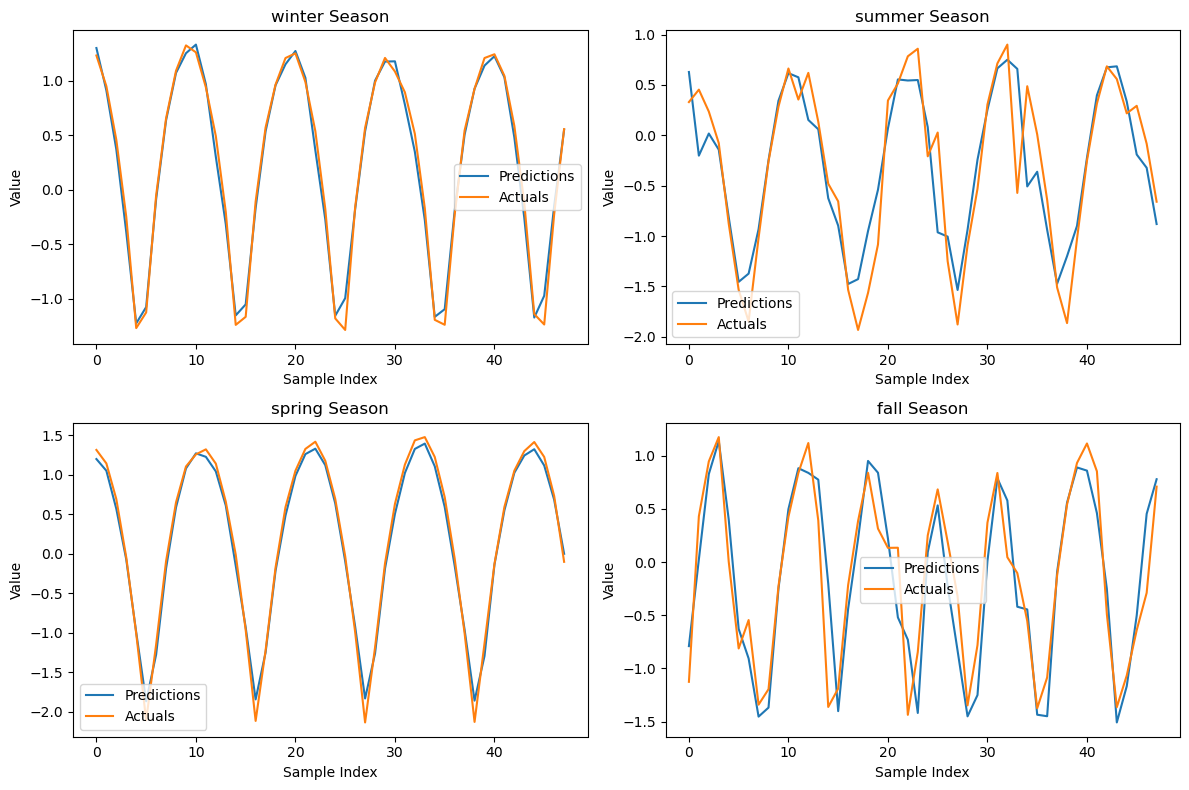

In [60]:
season_list_x = [X_winter, X_summer, X_spring,X_fall] 
season_list_y = [y_winter, y_summer, y_spring,y_fall] 
season_names = ["winter","summer","spring","fall"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()  

for idx, (i, j) in enumerate(zip(season_list_x, season_list_y)):
    train_predictions = best_model.predict(i).flatten()
    train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':j.flatten()})
    test_loss, test_mae, test_mba, test_rmae = best_model.evaluate(i, j)
    print(f'Test MAE: {season_names[idx]}, Test MBA: {test_mba}, Test RMAE: {test_rmae}%')
    ax = axes[idx]
    ax.plot(train_results['Train Predictions'][0:48], label='Predictions')
    ax.plot(train_results['Actuals'][0:48], label='Actuals')
    ax.set_title(f"{season_names[idx]} Season")
    ax.legend()
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')


plt.tight_layout()
plt.show()
    

# SIMPLE GRU

In [62]:
def build_optimized_gru_model():
    model = Sequential()
    seq_length=5
    num_features=8
    
    # Input layer
    model.add(InputLayer(input_shape=(seq_length, num_features)))
    
    # First GRU layer
    model.add(GRU(units=128, return_sequences=True))
    model.add(Dropout(rate=0.1))
    
    # Second GRU layer
    model.add(GRU(units=128, return_sequences=True))
    model.add(Dropout(rate=0.1))
    
    # Third GRU layer
    model.add(GRU(units=64))
    model.add(Dropout(rate=0.1))
    
    # Fully connected layer
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.1))
    
    # Output layer
    model.add(Dense(1))  # Linear activation for regression
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Instantiate the model
best_simple_model_gru=build_optimized_gru_model()

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode='min'
)

model_checkpoint = ModelCheckpoint(
    'model_optimized_SIMPLE_GRU_Best.keras',
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1
)



# print(best_model.summary())
history_GRU = best_simple_model_gru.fit(
    X_train1, y_train1,
    epochs=200,
    validation_data=(X_val1,y_val1),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    batch_size=64,
    verbose=1,
    shuffle=False
)

Epoch 1/200
665/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4141 - mae: 0.5003
Epoch 1: val_loss improved from inf to 0.18515, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.4128 - mae: 0.4993 - val_loss: 0.1852 - val_mae: 0.3084 - learning_rate: 1.0000e-04
Epoch 2/200
668/670 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1806 - mae: 0.3116
Epoch 2: val_loss improved from 0.18515 to 0.15085, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1806 - mae: 0.3115 - val_loss: 0.1508 - val_mae: 0.2698 - learning_rate: 1.0000e-04
Epoch 3/200
669/670 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1521 - mae: 0.2786
Epoch 3: val_loss improved from 0.15085 to 0.13426, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1521 - mae: 0.2786 - val_loss: 0.1343 - val_mae: 0.2467 - learning_rate: 1.0000e-04
Epoch 4/200
666/670 ━━━━━━━━━━━━━━━

664/670 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1098 - mae: 0.2156
Epoch 23: val_loss did not improve from 0.11239
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1098 - mae: 0.2156 - val_loss: 0.1125 - val_mae: 0.2009 - learning_rate: 1.0000e-04
Epoch 24/200
666/670 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1095 - mae: 0.2158
Epoch 24: val_loss improved from 0.11239 to 0.11095, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1096 - mae: 0.2158 - val_loss: 0.1110 - val_mae: 0.1980 - learning_rate: 1.0000e-04
Epoch 25/200
664/670 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1099 - mae: 0.2162
Epoch 25: val_loss did not improve from 0.11095
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1099 - mae: 0.2162 - val_loss: 0.1119 - val_mae: 0.2026 - learning_rate: 1.0000e-04
Epoch 26/200
665/670 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1094 - mae: 0.2146
Epoch 26: val_loss did not improve from 0.11095
670/670 ━━━━━━━━━━━━━━━━━

666/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1055 - mae: 0.2087
Epoch 46: val_loss improved from 0.10874 to 0.10871, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1055 - mae: 0.2087 - val_loss: 0.1087 - val_mae: 0.1929 - learning_rate: 1.0000e-04
Epoch 47/200
664/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1049 - mae: 0.2082
Epoch 47: val_loss did not improve from 0.10871
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1050 - mae: 0.2082 - val_loss: 0.1087 - val_mae: 0.1937 - learning_rate: 1.0000e-04
Epoch 48/200
670/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1049 - mae: 0.2088
Epoch 48: val_loss improved from 0.10871 to 0.10812, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1049 - mae: 0.2088 - val_loss: 0.1081 - val_mae: 0.1926 - learning_rate: 1.0000e-04
Epoch 49/200
665/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1051 - mae: 0.2078
Epoch 49: val_

Epoch 68/200
668/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1039 - mae: 0.2079
Epoch 68: val_loss improved from 0.10681 to 0.10681, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1039 - mae: 0.2079 - val_loss: 0.1068 - val_mae: 0.1874 - learning_rate: 1.0000e-07
Epoch 69/200
669/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1039 - mae: 0.2074
Epoch 69: val_loss improved from 0.10681 to 0.10681, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1039 - mae: 0.2073 - val_loss: 0.1068 - val_mae: 0.1873 - learning_rate: 1.0000e-07
Epoch 70/200
664/670 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1037 - mae: 0.2076
Epoch 70: val_loss improved from 0.10681 to 0.10681, saving model to model_optimized_SIMPLE_GRU_Best.keras
670/670 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1037 - mae: 0.2076 - val_loss: 0.1068 - val_mae: 0.1872 - learning_rate: 1.0000e-07
Epoch 71/200
664/670 ━━━━

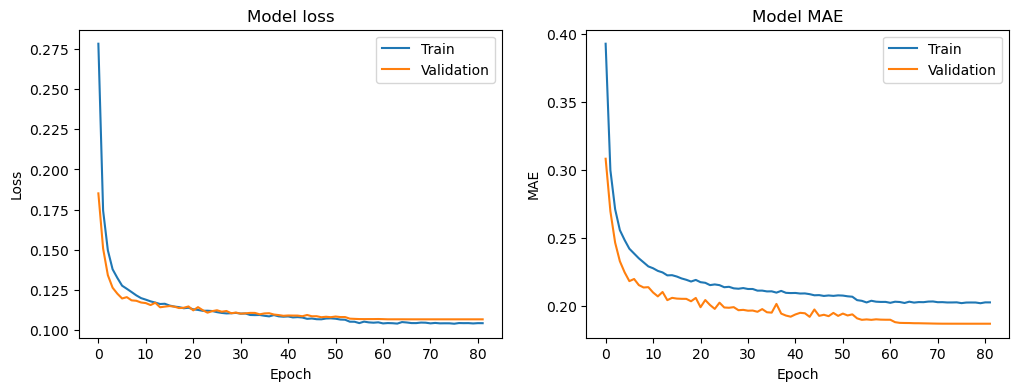

In [63]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history_GRU.history['mae'])
plt.plot(history_GRU.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 5, 128)         │        52,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 5, 128)         │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 580,613 (2.21 MB)

 Trainable params: 193,537 (756.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 387,076 (1.48 MB)

None
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


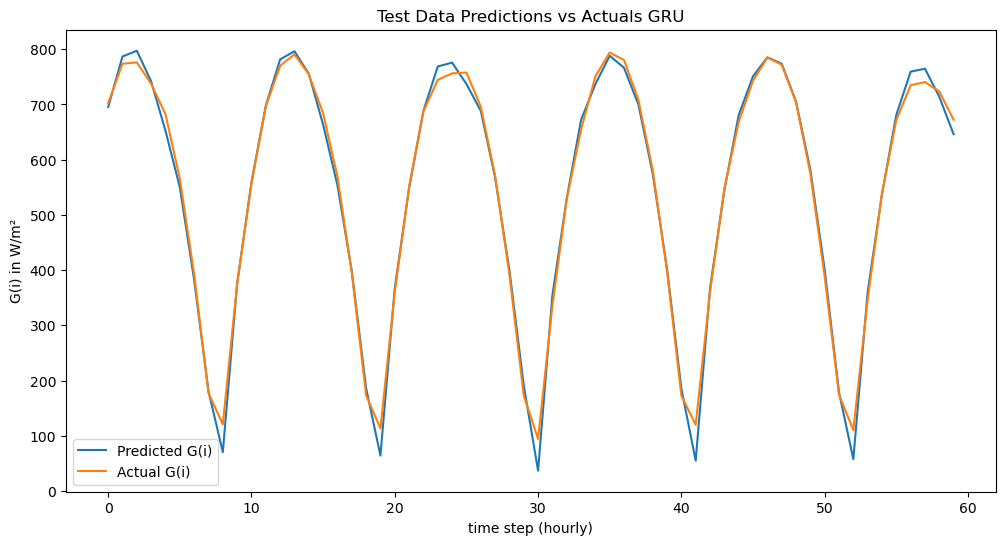

In [64]:
# Access the mean and standard deviation for the first feature
data_mean = scaler.mean_[0]
data_std = scaler.scale_[0]

# Load the best GRU model
best_model_gru = tf.keras.models.load_model('model_optimized_SIMPLE_GRU_Best.keras')
print(best_model_gru.summary())

# Predict on the test set and flatten the output
Test_prediction = best_model_gru.predict(X_test1).flatten()

# Manually inverse transform the predictions and actuals
Test_Predictions_transformed = Test_prediction * data_std + data_mean
y_test1_transformed = y_test1 * data_std + data_mean

# Prepare the DataFrame with actual and predicted values
test_results = pd.DataFrame({
    'Test Predictions': Test_Predictions_transformed,
    'Actuals': y_test1_transformed
})

# Plotting 
plt.figure(figsize=(12, 6))
plt.plot(test_results['Test Predictions'][0:60], label="Predicted G(i)")
plt.plot(test_results['Actuals'][0:60], label="Actual G(i)")
plt.ylabel('G(i) in W/m²')
plt.xlabel("time step (hourly)")
plt.title('Test Data Predictions vs Actuals GRU')
plt.legend()
plt.show()


# COMPLEX GRU

In [65]:
# Define model-building function for Keras Tuner
def build_gru_model(hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(5, 8)))  # Assuming input shape (5, 7) (or whatever shape you have)

    # Add a stack of GRU layers with increasing complexity
    model.add(GRU(units=hp.Int('gru_units_1', min_value=32, max_value=128, step=32), 
                  return_sequences=True))  # First GRU layer
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout

    model.add(GRU(units=hp.Int('gru_units_2', min_value=32, max_value=128, step=32), 
                  return_sequences=True))  # Second GRU layer
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout

    model.add(GRU(units=hp.Int('gru_units_3', min_value=32, max_value=128, step=32)))  # Final GRU layer
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout

    # Dense layers to increase model complexity
    model.add(Dense(units=hp.Int('dense_units_1', min_value=8, max_value=64, step=8), activation='relu'))  # Dense layer
    model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout

    model.add(Dense(units=hp.Int('dense_units_2', min_value=8, max_value=64, step=8), activation='relu'))  # Dense layer

    # Output layer for regression
    model.add(Dense(1, activation='linear'))

    # Compile the model with custom metrics
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss=MeanSquaredError(),
        metrics=[mae, mba, rmse]
    )

    return model

# Set up Keras Tuner
tuner = kt.Hyperband(
    build_gru_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='kt_gru_dir',
    project_name='gru_tuning'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1, mode='min')
cp1 = ModelCheckpoint('model_G(I)/gru_model_best.keras', save_best_only=True)

# Perform the hyperparameter search
tuner.search(
    X_train1, y_train1,
    epochs=50,
    validation_data=(X_val1, y_val1),
    callbacks=[early_stopping, cp1]
)

# Get the best model
best_model_gru = tuner.get_best_models(num_models=1)[0]

# You can print the best hyperparameters as well
best_hyperparameters_gru = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hyperparameters_gru.values)

# Fit the best model on the full dataset
history_gru = best_model_gru.fit(
    X_train1, y_train1,
    validation_data=(X_val1, y_val1),
    epochs=50,
    callbacks=[early_stopping, cp1]
)

Trial 30 Complete [00h 01m 14s]
val_loss: 0.12032202631235123

Best val_loss So Far: 0.12032202631235123
Total elapsed time: 00h 14m 39s
Best hyperparameters: {'gru_units_1': 96, 'dropout_1': 0.2, 'gru_units_2': 64, 'dropout_2': 0.30000000000000004, 'gru_units_3': 128, 'dropout_3': 0.2, 'dense_units_1': 24, 'dropout_4': 0.2, 'dense_units_2': 16, 'learning_rate': 0.005125742695923368, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Epoch 1/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1242 - mae: 1.0797 - mba: 0.0586 - rmse: 1.3476 - val_loss: 0.1330 - val_mae: 1.0383 - val_mba: 0.1119 - val_rmse: 1.2896
Epoch 2/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1253 - mae: 1.0865 - mba: 0.0576 - rmse: 1.3555 - val_loss: 0.1360 - val_mae: 1.0121 - val_mba: 0.0798 - val_rmse: 1.2547
Epoch 3/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1241 - mae: 1.0878 - mba: 0.0588 - rmse: 1.3580 - val_loss: 0.1411 - val_mae: 1.0143 - val_mb

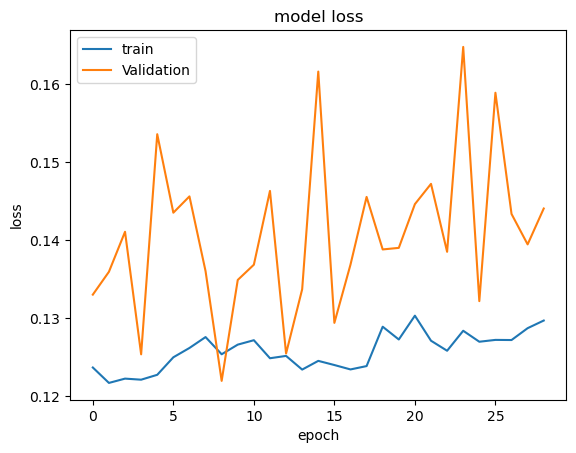

In [66]:
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0947 - mae: 1.0789 - mba: 0.0712 - rmse: 1.3437
Test MAE: winter, Test MBA: 0.06411511451005936, Test RMAE: 1.3494932651519775%
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2076 - mae: 0.8349 - mba: 0.0811 - rmse: 1.0260
Test MAE: summer, Test MBA: 0.08402805030345917, Test RMAE: 1.023604393005371%
549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1180 - mae: 1.0251 - mba: 0.0648 - rmse: 1.2685
Test MAE: spring, Test MBA: 0.06292306631803513, Test RMAE: 1.2587233781814575%
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1519 - mae: 1.0416 - mba: 0.0766 - rmse: 1.2802
Test MAE: fall, Test MBA: 0.07072975486516953, Test RMAE: 1.2794438600540161%


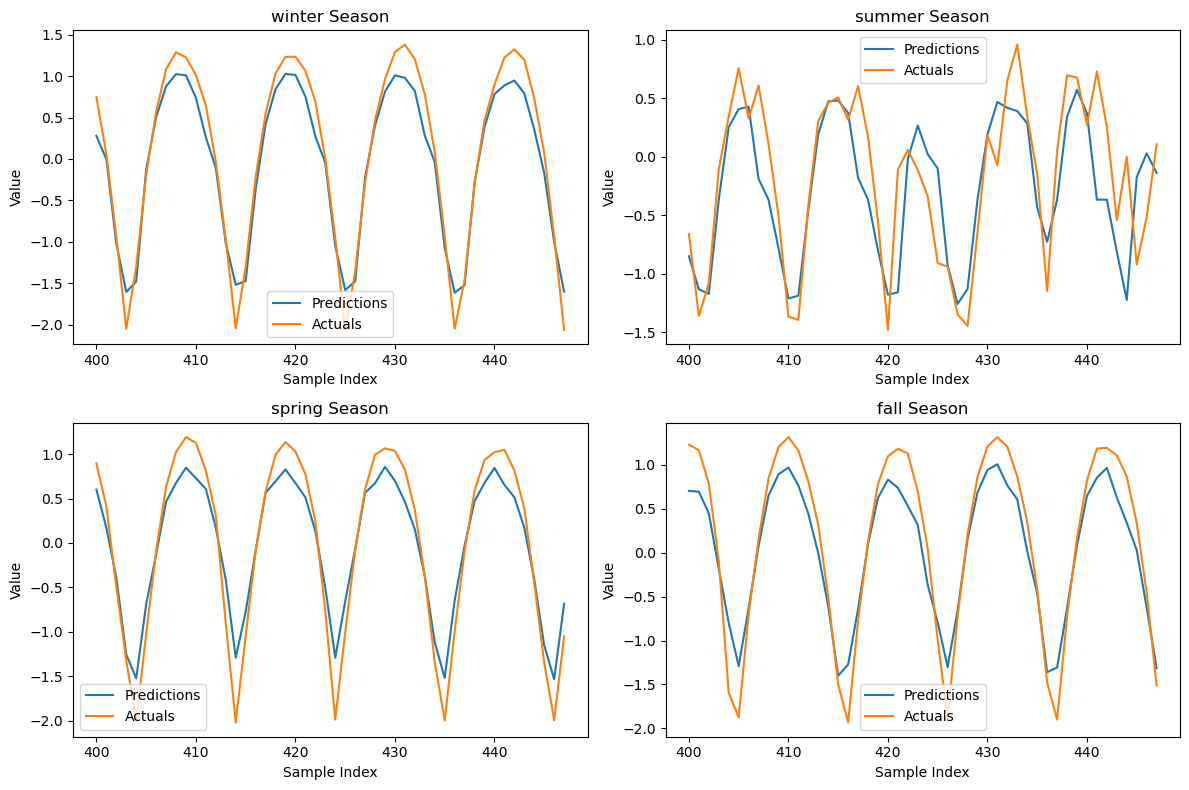

In [67]:
season_list_x = [X_winter, X_summer, X_spring,X_fall] 
season_list_y = [y_winter, y_summer, y_spring,y_fall] 
season_names = ["winter","summer","spring","fall"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()  

for idx, (i, j) in enumerate(zip(season_list_x, season_list_y)):
    train_predictions = best_model_gru.predict(i).flatten()
    train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':j.flatten()})
    test_loss, test_mae, test_mba, test_rmae = best_model_gru.evaluate(i, j)
    print(f'Test MAE: {season_names[idx]}, Test MBA: {test_mba}, Test RMAE: {test_rmae}%')
    ax = axes[idx]
    ax.plot(train_results['Train Predictions'][400:448], label='Predictions')
    ax.plot(train_results['Actuals'][400:448], label='Actuals')
    ax.set_title(f"{season_names[idx]} Season")
    ax.legend()
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')


plt.tight_layout()
plt.show()

# Hybrid

In [69]:
from keras.layers import Input, LSTM, Dense, Conv1D, ReLU, Add, Layer, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt

# Custom Residual Block with projection to match input and output shapes
class ResidualBlock(Layer):
    def __init__(self, filters, kernel_size, dilation_rate, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate)
        self.relu1 = ReLU()
        self.conv2 = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate)
        self.relu2 = ReLU()
        self.add = Add()
        
        # Projection layer to match input and output shapes if needed
        self.projection = Conv1D(filters=filters, kernel_size=1, padding='same') if filters != 64 else None
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.relu1(x)
        x = self.conv2(x)
        
        # Project input if necessary to match the shape
        if self.projection is not None:
            inputs = self.projection(inputs)
        
        x = self.add([inputs, x])  # Residual connection
        x = self.relu2(x)
        return x

# Define the model-building function for Keras Tuner
def build_model(hp):
    # Input shape for your data
    input_shape = (5, 8)  # Update this as per your data
    inputs = Input(shape=input_shape)
    
    # LSTM Layers
    x = LSTM(256, return_sequences=True)(inputs)
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64, return_sequences=False)(x)  # Output a single vector

    # Reshape to add an extra time dimension for Conv1D compatibility
    x = Reshape((1, 64))(x)  # Shape now is (batch_size, 1, 64)
    
    # Residual Blocks with increasing dilation rates (dilation_rate is tunable)
    for dilation_rate in [1, 2, 4]:
        x = ResidualBlock(
            filters=hp.Int('conv_filters', min_value=64, max_value=128, step=32),
            kernel_size=hp.Int('kernel_size', min_value=3, max_value=5, step=1),
            dilation_rate=dilation_rate
        )(x)
    
    # Flatten the output before passing to the final Dense layer
    x = Reshape((-1,))(x)  # Flatten to (batch_size, features)
    
    # Fully Connected (Dense) Layer with a single output
    x = Dense(units=1, activation='linear')(x)  # Single output value
    
    # Model creation
    model = Model(inputs=inputs, outputs=x)
    
    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='mse',  # Mean Squared Error for regression
        metrics=['mae']  # Only using MAE for simplicity
    )
    return model

# Set up the Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='tuner_project'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('model_G(I)/hybrid_model_best.keras', save_best_only=True)

# Start the search for the best model
tuner.search(X_train1, y_train1, epochs=50, validation_data=(X_val1, y_val1), callbacks=[early_stopping, model_checkpoint])

# Retrieve the best model
best_hybrid_model = tuner.get_best_models(num_models=1)[0]

# Model summary of the best model
best_hybrid_model.summary()

# Print the best hyperparameters
best_hyperparameters_hybrid = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hyperparameters_hybrid.values)

# Fit the best model on the full dataset
history_hybrid = best_hybrid_model.fit(
    X_train1, y_train1,
    validation_data=(X_val1, y_val1),
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)


Trial 18 Complete [00h 00m 39s]
val_loss: 0.12193717062473297

Best val_loss So Far: 0.11410478502511978
Total elapsed time: 00h 10m 40s


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 256)         │       271,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ (None, 1, 64)          │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1                │ (None, 1, 64)          │        41,088 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ (None, 1, 64)          │        41,088 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641,217 (2.45 MB)

 Trainable params: 641,217 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

Best hyperparameters: {'conv_filters': 64, 'kernel_size': 5, 'optimizer': 'adam', 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}
Epoch 1/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.1138 - mae: 0.2125 - val_loss: 0.1158 - val_mae: 0.2093
Epoch 2/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.1091 - mae: 0.2034 - val_loss: 0.1120 - val_mae: 0.1974
Epoch 3/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.1041 - mae: 0.1969 - val_loss: 0.1133 - val_mae: 0.2017
Epoch 4/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.1017 - mae: 0.1932 - val_loss: 0.1068 - val_mae: 0.1873
Epoch 5/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0995 - mae: 0.1878 - val_loss: 0.1063 - val_mae: 0.1877
Epoch 6/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0998 - mae: 0.1883 - val_loss: 0.1051 - val_mae: 0.1958
Epoch 7/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0970 - mae: 0.1850 - val_loss: 0.1043

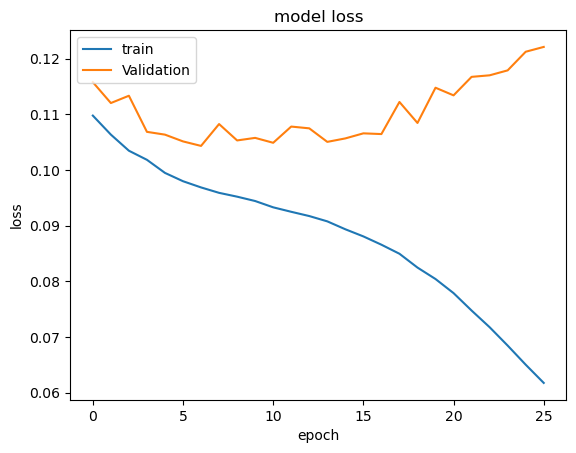

In [70]:
plt.plot(history_hybrid.history['loss'])
plt.plot(history_hybrid.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
549/549 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


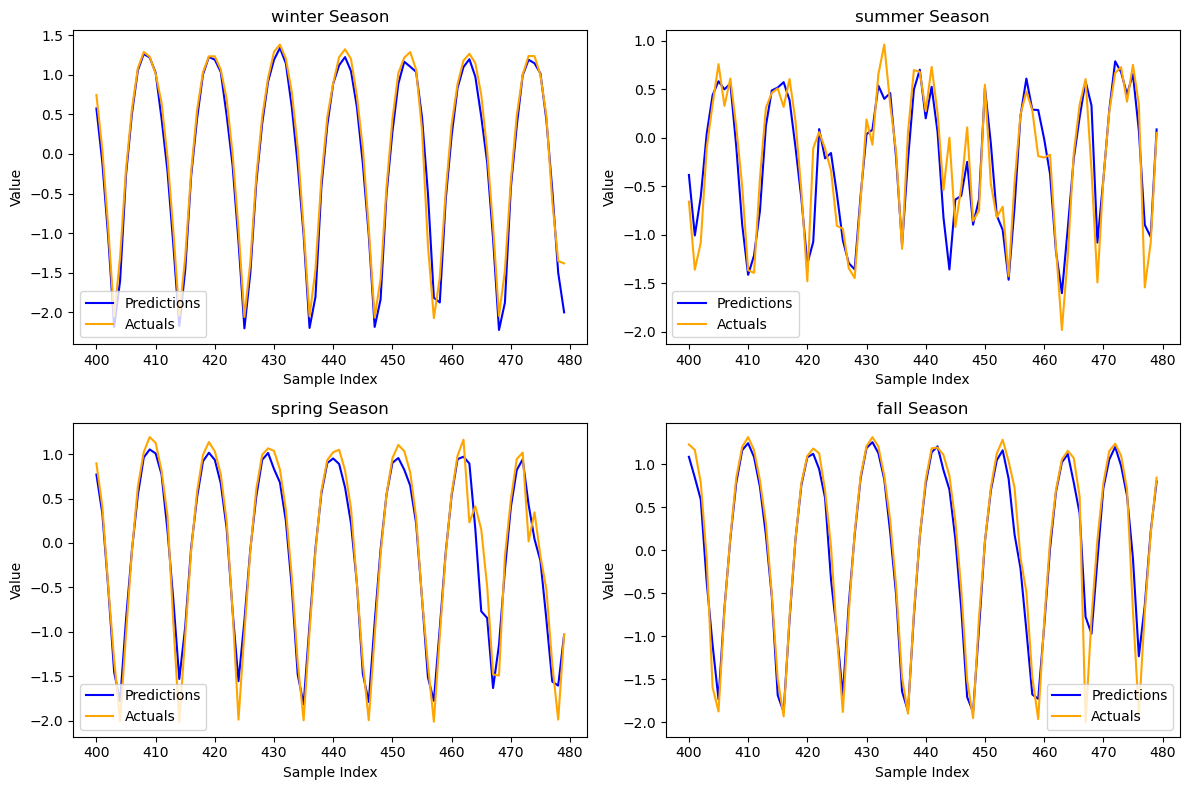

In [71]:
season_list_x = [X_winter, X_summer, X_spring, X_fall] 
season_list_y = [y_winter, y_summer, y_spring, y_fall] 
season_names = ["winter", "summer", "spring", "fall"]

# Create a 2x2 plot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# Loop through each season and plot predictions vs actual values
for idx, (X_season, y_season) in enumerate(zip(season_list_x, season_list_y)):
    train_predictions = best_hybrid_model.predict(X_season)
    
    # Flatten the predictions and actual values (if needed)
    train_predictions = train_predictions.flatten()
    y_season = y_season.flatten()

    # Create a DataFrame for easier comparison
    train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_season})

    # Plot the first 250 samples for better visualization
    ax = axes[idx]
    ax.plot(train_results['Train Predictions'][400:480], label='Predictions', color='blue')
    ax.plot(train_results['Actuals'][400:480], label='Actuals', color='orange')

    # Set title, labels, and legend
    ax.set_title(f"{season_names[idx]} Season")
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')
    ax.legend()

# Improve layout for clarity
plt.tight_layout()
plt.show()